## SEASONAL FARMING ADVISORY

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import string

from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

In [4]:
# Load and preprocess data
def get_data(data_file):
    access_monthly = xr.open_dataset(data_file)
    access_mon = access_monthly.sel(lat=slice(-12, 0), lon=slice(140, 157))
    new_latitudes = np.linspace(-12, 0, 131)
    new_longitudes = np.linspace(140, 157, 181)
    access_mon = access_mon.interp(lat=new_latitudes, lon=new_longitudes, method='linear')
    return access_mon

In [5]:
# Process data for a specific month and tercile
def parse_data(data, month_idx, tercile_idx):
    probB = data['probB'][month_idx]
    probN = data['probN'][month_idx]
    probA = data['probA'][month_idx]

    arr_probs = np.array([probB, probN, probA])
    sort_probs = np.sort(arr_probs, axis=0)

    n_sort = sort_probs[-tercile_idx]  # Select the nth tercile (e.g., 1 for highest, 2 for middle, 3 for lowest)
    n_tercile_arr = np.where(n_sort == probB, 'below normal', np.where(n_sort == probN, 'near normal', 'above normal'))
    n_tcon_array = np.where(n_tercile_arr == 'below normal', n_sort / 10, np.where(n_tercile_arr == 'near normal', (n_sort / 10) + 10, (n_sort / 10) + 20))
    
    return n_tcon_array, n_tercile_arr, n_sort


In [6]:
tercile_color2 = ['#fefefe', '#ffeda0', '#fecb65', '#e09345', '#cb6430', '#b04b26', '#97341e'
                ,'#fefefe','#e6e6e6', '#d7d7d7', '#cacaca', '#b9b9b9', '#a3a3a3', '#858585'
                ,'#fefefe','#cbfdcb', '#a7dabc', '#82b7b0', '#5d94a3', '#336699', '#124d87']
excedance_color = ['#fefefe','#febe58','#feac00','#fefe00', '#b3fe00', '#4bfe00','#00e598',
                   '#00a5fe','#3d3dfe','#b200fe','#fe00fe','#fe4b9a']
excedance_cmap = ListedColormap(excedance_color)
tercile_cmap2 = ListedColormap(tercile_color2)

In [7]:
# Function to get province geometries and districts
def get_province_shapes(province_name, shapefile_path_prov, shapefile_path_dist):
    gdf_prov = gpd.read_file(shapefile_path_prov)
    gdf_distr = gpd.read_file(shapefile_path_dist)

    province_gdf = gdf_prov[gdf_prov['PROVNAME'] == province_name]
    prov_bound = province_gdf.unary_union
    prov_districts_gdf = gdf_distr[gdf_distr.within(prov_bound)]
    
    return province_gdf, prov_districts_gdf

In [8]:
# Modified function to add district labels and legend
def add_district_labels_and_legend(ax, districts_gdf, display_legend=True):
    # Generate a mapping of district names to letters
    district_names = districts_gdf['DISTNAME'].tolist()
    letters = list(string.ascii_uppercase)[:len(district_names)]
    district_mapping = dict(zip(letters, district_names))

    # Add labels to the districts
    for letter, (x, y) in zip(letters, zip(districts_gdf.geometry.centroid.x, districts_gdf.geometry.centroid.y)):
        ax.text(x, y, letter, fontsize=14, ha='center')

    # Optionally create legend
    if display_legend:
        legend_text = '\n'.join([f'{letter}: {name}' for letter, name in district_mapping.items()])
        plt.gcf().text(0.9, 0.5, legend_text, fontsize=12, verticalalignment='center')

    return district_mapping

In [9]:
# Function to add custom images as colorbars
def add_custom_colorbars(fig, img_paths, positions):
    for img_path, pos in zip(img_paths, positions):
        img = mpimg.imread(img_path)
        ax_img = fig.add_axes(pos, anchor='C', zorder=1)
        ax_img.imshow(img)
        ax_img.axis('off')

In [94]:
# Plot multiple months in subplots
def plot_multiple_months(data, start_month_idx, tercile_idx, num_months=5, province_name='Eastern Highlands', display_legend=False):
    # Load shapefiles
    shapefile_path_prov = 'PNG_admin_boundary/png_prov_boundaries_2011census_region.shp'
    shapefile_path_dist = 'PNG_admin_boundary/png_dist_boundaries_2011census_region.shp'
    
    province_gdf, prov_districts_gdf = get_province_shapes(province_name, shapefile_path_prov, shapefile_path_dist)
    forecast_periods = data['forecast_period'].values.astype(str)
    fig, axs = plt.subplots(1, 5, figsize=(24, 6), sharey=True)
    
    custom_levels = [0, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 19, 20, 24, 25, 26, 27, 28, 29, 30]
    norm = BoundaryNorm(custom_levels, len(custom_levels) - 1)
    #tercile_cmap2 = plt.get_cmap('coolwarm')

    for plot_count in range(num_months):
        ax = axs[plot_count]
        month_idx = start_month_idx + plot_count
        n_tcon_array,_,_ = parse_data(data, month_idx, tercile_idx)

        da = xr.DataArray(n_tcon_array, coords={'lat':data['lat'], 'lon':data['lon']}, dims=['lat', 'lon'])

        im = da.plot(ax=ax, add_colorbar=False, cmap=tercile_cmap2, levels=custom_levels)

        # Shapefiles
        province_gdf.geometry.plot(ax=ax, color='none', edgecolor='black', linewidth=1)
        prov_districts_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=0.2, linestyle='--')

        # Set the extent
        extent = [144.95, 146.2, -7.2, -5.8] # Eastern Highlands Extent
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])

        # Add district labels and legend
        add_district_labels_and_legend(ax, prov_districts_gdf, display_legend)

        # Set title with forecast period
        ax.set_title(f'{forecast_periods[month_idx]}', fontsize=18)
    
     # Add custom images as colorbars
    img_paths = ['assets/below_scale.png', 'assets/near_scale.png', 'assets/above_scale.png']
    positions = [[0.1, 0.01, 0.2, 0.13], [0.3, 0.01, 0.2, 0.13], [0.5, 0.01, 0.2, 0.13]]
    add_custom_colorbars(fig, img_paths, positions)
    # Colorbar
    #cbar = fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.02, pad=0.1)
    #cbar.set_label('Percent %', size='large')
    #cbar.set_ticks([])  # Remove ticks from the colorbar
    plt.subplots_adjust(left=0.05, right=0.85, top=0.8, bottom=0.24, wspace=0.3)
    plt.suptitle(f'Tercile Rainfall Probabilities For {province_name} Province', fontsize=22, y=0.95)
    ax.text(139, -7.9, f'FOrecast Date: {data.forecast_date}', fontsize=9)
    ax.text(140, -7.9, f'Source: ACCESS-S2', fontsize=9)
    plt.savefig(f'output/{province_name}_latest_tercile_forecast.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'archive/{data.forecast_date}_{province_name}_tercile_forecast.png', dpi=300, bbox_inches='tight')

    plt.show()

In [95]:
# Function to plot the total rainfall exceedance maps for multiple months
def plot_exceedance_maps(data, start_month_idx, num_months=3, province_name='Eastern Highlands', custom_levels=None):
    """
    Plot multiple contour maps of total rainfall for a range of months with province shapes, district labels, and legend.
    
    Parameters:
    - data: xarray dataset containing the 'total_rain' variable.
    - start_month_idx: Starting index of the month to plot.
    - num_months: Number of months to plot (default is 5).
    - province_name: Name of the province to overlay shapes for.
    - custom_levels: List of custom levels for the color scale (optional).
    """
    # Load shapefiles
    shapefile_path_prov = 'PNG_admin_boundary/png_prov_boundaries_2011census_region.shp'
    shapefile_path_dist = 'PNG_admin_boundary/png_dist_boundaries_2011census_region.shp'

    # Get province and district geometries
    province_gdf, prov_districts_gdf = get_province_shapes(province_name, shapefile_path_prov, shapefile_path_dist)
    
    # Set default custom levels if not provided
    if custom_levels is None:
        custom_levels = [0, 25, 50, 100, 150, 200, 250, 300, 400, 500, 600, 800]
    
    # Use BoundaryNorm to map the levels correctly with the colors
    norm = BoundaryNorm(custom_levels, len(custom_levels) - 1)
    
    # Create subplots
    fig, axs = plt.subplots(1, num_months, figsize=(24, 6), sharey=True)

    for plot_count in range(num_months):
        ax = axs[plot_count]
        month_idx = start_month_idx + plot_count
        
        # Select the data for the given month (time index)
        lon = data['lon'].values
        lat = data['lat'].values
        total_rain = data['total_rain'].isel(time=month_idx).values  # Select time step

        # Plot the rainfall data as a contour map with custom levels
        contour = ax.contourf(lon, lat, total_rain, levels=custom_levels, cmap=excedance_cmap, norm=norm, extend='max')
        
        # Plot province and district shapes
        province_gdf.geometry.plot(ax=ax, color='none', edgecolor='black', linewidth=1)
        prov_districts_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=0.2, linestyle='--')
        
        # Add district labels and legend
        add_district_labels_and_legend(ax, prov_districts_gdf, display_legend=False)

        # Set the extent
        extent = [144.95, 146.2, -7.2, -5.8]  # Example extent for Eastern Highlands
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])

        # Set title with the time step or month
        forecast_periods = data['forecast_period'].values.astype(str)
        ax.set_title(f'{forecast_periods[month_idx]}', fontsize=14)

    # Add color bar with custom ticks
    cbar = fig.colorbar(contour, ax=axs, orientation='horizontal', fraction=0.08, pad=0.1)
    cbar.set_ticks(custom_levels)
    cbar.set_ticklabels([str(level) for level in custom_levels])
    cbar.set_label('Total Rainfall (mm)')
    ax.text(141.8, -7.8, f'Forecast Date: {data.forecast_date}', fontsize=9) # Fix: 
    ax.text(142.8, -7.8, f'Source: ACCESS-S1', fontsize=9)
    plt.suptitle(f'75% chance of rainfall exceeding X mm - {province_name}', fontsize=18, y=0.95)
    plt.subplots_adjust(left=0.25, right=0.75, top=0.83, bottom=0.26, wspace=0.1)
    plt.savefig(f'output/{province_name}_latest_exceedance_forecast.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'archive/{data.forecast_date}_{province_name}_exceedance_forecast.png', dpi=300, bbox_inches='tight')
    plt.show()


In [12]:
from config.config import DATA_DIR
import os

In [80]:
# Shapefiles path
shapefile_path_prov = 'PNG_admin_boundary/png_prov_boundaries_2011census_region.shp'
shapefile_path_dist = 'PNG_admin_boundary/png_dist_boundaries_2011census_region.shp'

#data_file = 'data/rain.forecast.terciles.monthly_20240408.nc'
data_path_tercile = os.path.join(DATA_DIR, 'terciles/rain.forecast.terciles.monthly_20240926.nc')
data_path_senario = os.path.join(DATA_DIR, 'scenario/rain.forecast.scenario.pacific.75.monthly_20241001.nc')

access_mon_tr = get_data(data_path_tercile)
access_mon_ex = get_data(data_path_senario)

/tmp/ipykernel_9110/735945596.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for letter, (x, y) in zip(letters, zip(districts_gdf.geometry.centroid.x, districts_gdf.geometry.centroid.y)):
/tmp/ipykernel_9110/735945596.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for letter, (x, y) in zip(letters, zip(districts_gdf.geometry.centroid.x, districts_gdf.geometry.centroid.y)):
/tmp/ipykernel_9110/735945596.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for letter, (x, y) in zip(letters, zip(districts_gdf.geometry.centroid.x, districts_gdf.geometry.centroid.y))

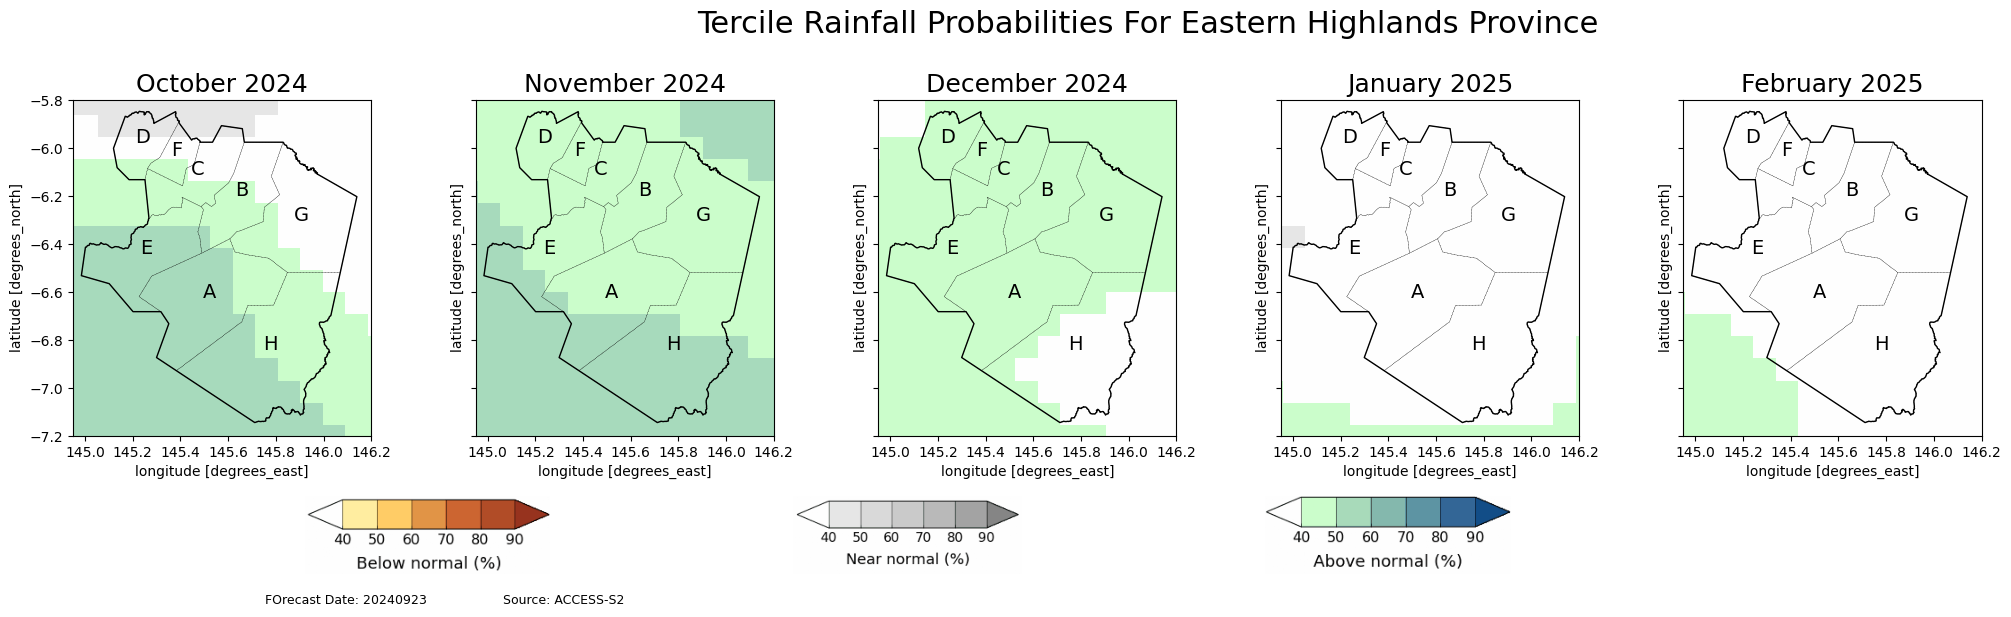

In [96]:
# Define starting month and tercile indices
start_month_idx = 0  # Start from the first month
tercile_idx = 1  # Tercile index (1 for highest, 2 for middle, 3 for lowest)

plot_multiple_months(access_mon_tr, start_month_idx, tercile_idx)

/tmp/ipykernel_9110/735945596.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for letter, (x, y) in zip(letters, zip(districts_gdf.geometry.centroid.x, districts_gdf.geometry.centroid.y)):
/tmp/ipykernel_9110/735945596.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for letter, (x, y) in zip(letters, zip(districts_gdf.geometry.centroid.x, districts_gdf.geometry.centroid.y)):
/tmp/ipykernel_9110/735945596.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for letter, (x, y) in zip(letters, zip(districts_gdf.geometry.centroid.x, districts_gdf.geometry.centroid.y))

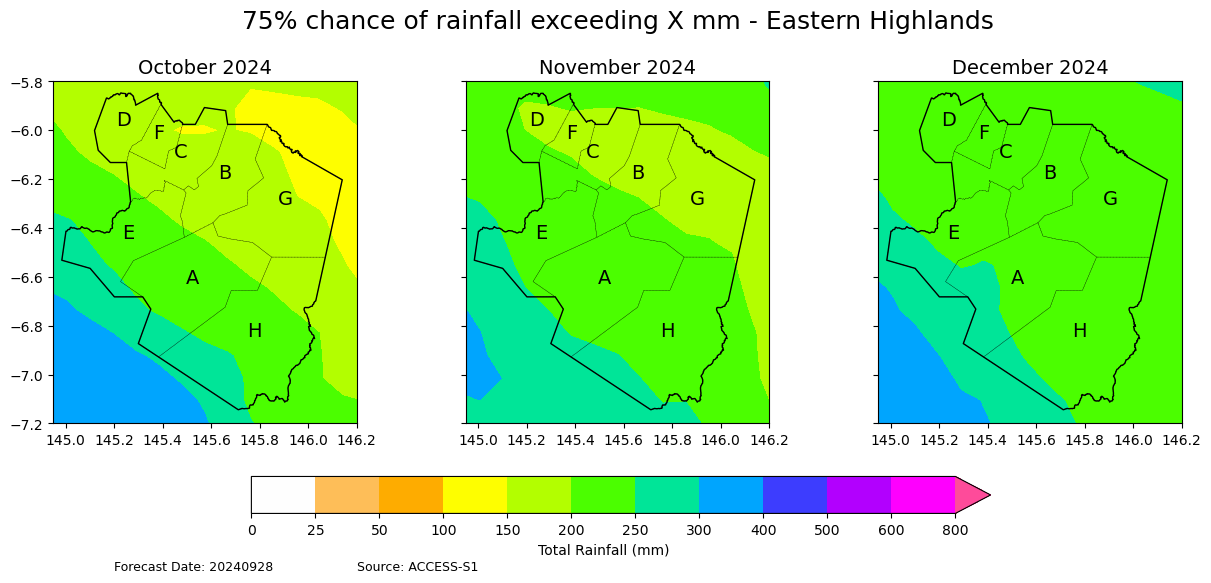

In [97]:
plot_exceedance_maps(access_mon_ex, start_month_idx)

In [16]:
import pandas as pd
from shapely.geometry import Point

In [100]:
def rainfall_stat_csv(data, num_month=0, province_name='Eastern Highlands'):
    # Prepare DataFrame to store detailed results
    results_df = pd.DataFrame(columns=['District', 'Latitude', 'Longitude'])

    # Get the month names from forecast_periods
    forecast_periods = data['forecast_period'].values.astype(str)

    # Get province and district geometries
    _, prov_districts_gdf = get_province_shapes(province_name, shapefile_path_prov, shapefile_path_dist)

    # Loop through the months from 0 to 4
    for month_idx in range(5):
        _, n_tercile_arr, n_sort = parse_data(data, month_idx, tercile_idx)
        lon_2d, lat_2d = np.meshgrid(data['lon'], data['lat'])

        # Temporary DataFrame to hold month data
        month_df = pd.DataFrame(columns=['District', 'Latitude', 'Longitude', 
                                         f'{forecast_periods[month_idx]} Probability', 
                                         f'{forecast_periods[month_idx]} Tercile'])

        # Loop through each district
        for _, district in prov_districts_gdf.iterrows():
            district_name = district['DISTNAME']
            district_geom = district.geometry

            # Prepare a list to store the rows for the current district
            rows = []

            # Loop through each grid cell
            for x in range(len(lon_2d[0])):
                for y in range(len(lat_2d)):
                    lon_value = lon_2d[y, x]
                    lat_value = lat_2d[y, x]
                    grid_point = Point(lon_value, lat_value)

                    if district_geom.contains(grid_point) or district_geom.touches(grid_point):
                        value = n_sort[y, x]
                        anom = n_tercile_arr[y, x]
                        rows.append({
                            'District': district_name,
                            'Latitude': lat_value,
                            'Longitude': lon_value,
                            f'{forecast_periods[month_idx]} Probability': value,
                            f'{forecast_periods[month_idx]} Tercile': anom
                        })

            # Append rows for the current month
            month_df = pd.concat([month_df, pd.DataFrame(rows)], ignore_index=True)

        # Merge month data with the main results DataFrame
        results_df = pd.merge(results_df, month_df, how='outer', on=['District', 'Latitude', 'Longitude'])

    # Reorder columns so that Numeric Value and Anomaly of the same month are next to each other
    col_order = ['District', 'Latitude', 'Longitude']
    for month_idx in range(5):
        col_order.append(f'{forecast_periods[month_idx]} Probability')
        col_order.append(f'{forecast_periods[month_idx]} Tercile')

    # Apply the new column order
    results_df = results_df[col_order]

    # Save the detailed results to a CSV file
    results_df.to_csv(f"output/{province_name}_detailed_summary_stat.csv", index=False)
    results_df.to_csv(f"archive/csv/{data.forecast_date}_{province_name}_detailed_summary_stat.csv")
    # Define a mapping for the 'Anomaly' values
    anomaly_mapping = {
        'below normal': -1,
        'normal': 0,
        'above normal': 1
    }

    # Apply the mapping to all anomaly columns
    for month_idx in range(5):
        results_df[f'{forecast_periods[month_idx]} Tercile'] = results_df[f'{forecast_periods[month_idx]} Tercile'].map(anomaly_mapping)

    # Calculate the average numeric value and anomaly for each district across months
    anomaly_cols = [f'{forecast_periods[month_idx]} Tercile' for month_idx in range(5)]
    numeric_value_cols = [f'{forecast_periods[month_idx]} Probability' for month_idx in range(5)]

    # Calculate averages per district
    average_df = results_df.groupby('District').agg({
        **{col: 'mean' for col in numeric_value_cols},
        **{col: 'mean' for col in anomaly_cols}
    }).reset_index()

    # Define the reverse mapping for the 'Anomaly' values
    reverse_anomaly_mapping = {
        -1: 'Below Normal',
        0: 'Normal',
        1: 'Above Normal'
    }

    # Apply reverse mapping for averaged anomaly values
    for month_idx in range(5):
        average_df[f'{forecast_periods[month_idx]} Tercile'] = average_df[f'{forecast_periods[month_idx]} Tercile'].round().map(reverse_anomaly_mapping)

    # Reorder columns in average_df so that Numeric Value and Anomaly for each month are side by side
    avg_col_order = ['District']
    for month_idx in range(5):
        avg_col_order.append(f'{forecast_periods[month_idx]} Probability')
        avg_col_order.append(f'{forecast_periods[month_idx]} Tercile')

    # Apply the new column order to average_df
    average_df = average_df[avg_col_order]

    # Save the average outlook to a CSV file
    average_df.to_csv(f'./output/{province_name}_summary_stat.csv', index=False)
    average_df.to_csv(f'./archive/csv/{data.forecast_date}_{province_name}_summary_stat.csv')
    

In [101]:
rainfall_stat_csv(access_mon_tr,0, province_name="Eastern Highlands")

/tmp/ipykernel_9110/1839553286.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  month_df = pd.concat([month_df, pd.DataFrame(rows)], ignore_index=True)
/tmp/ipykernel_9110/1839553286.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  month_df = pd.concat([month_df, pd.DataFrame(rows)], ignore_index=True)
/tmp/ipykernel_9110/1839553286.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude em